In [2]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/openfoamDATA/all_data_vanKarman.hdf5' all_data.hdf5

In [3]:
!cp '/content/drive/MyDrive/all_data_vanKarman_reduced.hdf5' all_data.hdf5

^C


In [4]:
from keras.callbacks import EarlyStopping, TensorBoard
import tensorflow as tf
import os
import shutil
import time
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import math

# Read and prepare data

# read data with x,y

In [6]:
from numba import njit
def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    data = hdf5_file["sim_data"][:, ...]

    data = data[:117,:,:,:] 

    times = data.shape[1] - 1
    hdf5_file.close()

    for j in range(data.shape[0]):
      for i in range(data.shape[1]-1):
        x.append(data[j, i, :,:]) 
        y.append(data[j, i+1,:,:])

    data = None

    x = np.array(x)
    y = np.array(y)
    y= y[:,:,:3]

    @njit
    def index(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx
        # If no item was found return None, other return types might be a problem due to
        # numbas type inference.

    max_0 = np.max( x[...,0] )
    max_1 = np.max( x[...,1] )
    max_2 = np.max( x[...,2] )

    x_mod = x * (x!=-100)

    min_0 = np.min( x_mod[...,0] )
    min_1 = np.min( x_mod[...,1] )
    min_2 = np.min( x_mod[...,2] )

    max_min = [max_0, max_1, max_2 , min_0 , min_1 ,min_2]

    for i in range(int(y.shape[0]/times)):
      #indice = np.where(y[i,:,0:3] == np.ones(shape=(1,3))* (-100.0))[0][0] #finding out the first padded value to not mess with it in the process - the padded continues being -100.0 
      indice = index(y[i*times+1,:,0] , -100.0 )[0]
      y[times*i:times*(i+1),:indice,0] = (y[times*i:times*(i+1),:indice,0] - np.ones((y[times*i:times*(i+1),:indice,0].shape))*min_0)/(max_0-min_0)
      y[times*i:times*(i+1),:indice,1] = (y[times*i:times*(i+1),:indice,1] - np.ones((y[times*i:times*(i+1),:indice,1].shape))*min_1)/(max_1-min_1)
      y[times*i:times*(i+1),:indice,2] = (y[times*i:times*(i+1),:indice,2] - np.ones((y[times*i:times*(i+1),:indice,2].shape))*min_2)/(max_2-min_2)


    for i in range(int(x.shape[0]/times)):
      #indice = np.where(x[i,:,0:3] == np.ones(shape=(1,3))* (-100.0))[0][0] #finding out the first padded value to not mess with it in the process - the padded continues being -100.0 
      indice = index(x[i*times+1,:,0] , -100.0 )[0]
      x[times*i:times*(i+1),:indice,0] = (x[times*i:times*(i+1),:indice,0] - np.ones((x[times*i:times*(i+1),:indice,0].shape))*min_0)/(max_0-min_0)
      x[times*i:times*(i+1),:indice,1] = (x[times*i:times*(i+1),:indice,1] - np.ones((x[times*i:times*(i+1),:indice,1].shape))*min_1)/(max_1-min_1)
      x[times*i:times*(i+1),:indice,2] = (x[times*i:times*(i+1),:indice,2] - np.ones((x[times*i:times*(i+1),:indice,2].shape))*min_2)/(max_2-min_2)



    t = np.zeros(shape=(x.shape[0],x.shape[1],1))

    for i in range(x.shape[0]):
      t[i,:,:] = np.ones((x.shape[1],1)) * (i - math.floor(i/(times+1))*(times+1)+1)

    x = np.concatenate((x,t), axis=2)

    total_sim = (x.shape[0])/times  #divide this way to make testing easier - x_test[0] will be the first time step of one sim

    x_train = x[:(int(total_sim * split)*times), ...]
    x_test = x[(int(total_sim * split)*times):int(total_sim)*times, ...]
    x = None

    y_train = y[:(int(total_sim * split)*times), ...]
    y_test = y[(int(total_sim * split)*times):int(total_sim)*times, ...]
    y = None
    #sim_no_train = sim_no[:int(total_sim * split), ...]
    #sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test, max_min

In [ ]:
from numba import njit
def read_dataset(path=None, split=0.9, print_shape=False):

    x = []
    y = []
    hdf5_file = h5py.File(path, "r")
    data = hdf5_file["sim_data"][:, ...]

    data = data[:117,:,:,:] 

    times = data.shape[1] - 1
    hdf5_file.close()

    for j in range(data.shape[0]):
      for i in range(data.shape[1]-1):
        x.append(data[j, i, :,:]) 
        y.append(data[j, i+1,:,:])

    data = None

    x = np.array(x)
    y = np.array(y)
    y= y[:,:,:3]

    @njit
    def index(array, item):
        for idx, val in np.ndenumerate(array):
            if val == item:
                return idx
        # If no item was found return None, other return types might be a problem due to
        # numbas type inference.

    print(y.shape[0])
    print(times)
    for i in range(int(y.shape[0]/times)):
      #indice = np.where(y[i,:,0:3] == np.ones(shape=(1,3))* (-100.0))[0][0] #finding out the first padded value to not mess with it in the process - the padded continues being -100.0 
      indice = index(y[i*times+1,:,0] , -100.0 )[0]
      if np.max(y[times*i:times*(i+1),:indice,0])-np.min(y[times*i:times*(i+1),:indice,0]) != 0:
        y[times*i:times*(i+1),:indice,0] = (y[times*i:times*(i+1),:indice,0] - np.ones((y[times*i:times*(i+1),:indice,0].shape))*np.min(y[times*i:times*(i+1),:indice,0]))/(np.max(y[times*i:times*(i+1),:indice,0])-np.min(y[times*i:times*(i+1),:indice,0]))
        y[times*i:times*(i+1),:indice,1] = (y[times*i:times*(i+1),:indice,1] - np.ones((y[times*i:times*(i+1),:indice,1].shape))*np.min(y[times*i:times*(i+1),:indice,1]))/(np.max(y[times*i:times*(i+1),:indice,1])-np.min(y[times*i:times*(i+1),:indice,1]))
        y[times*i:times*(i+1),:indice,2] = (y[times*i:times*(i+1),:indice,2] - np.ones((y[times*i:times*(i+1),:indice,2].shape))*np.min(y[times*i:times*(i+1),:indice,2]))/(np.max(y[times*i:times*(i+1),:indice,2])-np.min(y[times*i:times*(i+1),:indice,2]))


    for i in range(int(x.shape[0]/times)):
      #indice = np.where(x[i,:,0:3] == np.ones(shape=(1,3))* (-100.0))[0][0] #finding out the first padded value to not mess with it in the process - the padded continues being -100.0 
      indice = index(x[i*times+1,:,0] , -100.0 )[0]

      if np.max(x[times*i:times*(i+1),:indice,0])-np.min(x[times*i:times*(i+1),:indice,0]) != 0:
        x[times*i:times*(i+1),:indice,0] = (x[times*i:times*(i+1),:indice,0] - np.ones((x[times*i:times*(i+1),:indice,0].shape))*np.min(x[times*i:times*(i+1),:indice,0]))/(np.max(x[times*i:times*(i+1),:indice,0])-np.min(x[times*i:times*(i+1),:indice,0]))
        x[times*i:times*(i+1),:indice,1] = (x[times*i:times*(i+1),:indice,1] - np.ones((x[times*i:times*(i+1),:indice,1].shape))*np.min(x[times*i:times*(i+1),:indice,1]))/(np.max(x[times*i:times*(i+1),:indice,1])-np.min(x[times*i:times*(i+1),:indice,1]))
        x[times*i:times*(i+1),:indice,2] = (x[times*i:times*(i+1),:indice,2] - np.ones((x[times*i:times*(i+1),:indice,2].shape))*np.min(x[times*i:times*(i+1),:indice,2]))/(np.max(x[times*i:times*(i+1),:indice,2])-np.min(x[times*i:times*(i+1),:indice,2]))



    t = np.zeros(shape=(x.shape[0],x.shape[1],1))

    for i in range(x.shape[0]):
      t[i,:,:] = np.ones((x.shape[1],1)) * (i - math.floor(i/(times+1))*(times+1)+1)

    x = np.concatenate((x,t), axis=2)

    total_sim = (x.shape[0])/times  #divide this way to make testing easier - x_test[0] will be the first time step of one sim

    x_train = x[:(int(total_sim * split)*times), ...]
    x_test = x[(int(total_sim * split)*times):int(total_sim)*times, ...]
    x = None

    y_train = y[:(int(total_sim * split)*times), ...]
    y_test = y[(int(total_sim * split)*times):int(total_sim)*times, ...]
    y = None
    #sim_no_train = sim_no[:int(total_sim * split), ...]
    #sim_no_test = sim_no[int(total_sim * split):total_sim, ...]

    if print_shape:
        print("total_sim: {}\nx_train.shape: {}\ny_train.shape: {}\nx_test.shape: {}\ny_test.shape: {}\n".format(
            total_sim,
            x_train.shape,
            y_train.shape,
            x_test.shape,
            y_test.shape))

    return x_train, y_train, x_test, y_test

In [7]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test, max_min_list = read_dataset(hdf5_path, split=0.8, print_shape=True)

assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))

assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))

total_sim: 117.0
x_train.shape: (4650, 13104, 6)
y_train.shape: (4650, 13104, 3)
x_test.shape: (1200, 13104, 6)
y_test.shape: (1200, 13104, 3)



In [ ]:
train_len = x_train.shape[0]

# Loss function

x_train : (n,50,150,5)

last collumn: 0-ux 1-uy 2-p 3-x 4-y

In [ ]:
from numpy import random
@tf.function
def f_model(train):
  
  dtype = "float32"

  #num = 32

  #idxs=random.randint(train.shape[0], size=(num)) 
  #idxs = np.array(idxs)
  
  #train = train[idxs,:,:]
  #ux = train[:,:,0]
  #uy = train[:,:,1]
  #p = train[:,:,2]
  x = tf.convert_to_tensor(train[:,:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    #X_f = tf.stack([ux , uy , p , x, y , t], axis=2)
    X_f = tf.stack([x, y , t], axis=2)

    y_pred = model(X_f)

    ux = y_pred[:,:,0]
    uy = y_pred[:,:,1]
    p = y_pred[:,:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  ux_t = tape.gradient(ux,t)
  uy_t = tape.gradient(uy,t)

  ux_xx = tape.gradient(ux_x,x)
  ux_yy = tape.gradient(ux_y,y)

  uy_xx = tape.gradient(uy_x,x)
  uy_yy = tape.gradient(uy_y,y)

  p_x = tape.gradient(p,x)
  p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.square(res)
  NSx_residual = tf.square(residual_NS_x)
  NSy_residual = tf.square(residual_NS_y)

  return cont_residual, NSx_residual, NSy_residual

In [ ]:
def eq_loss():
  def equation_loss(y_true, y_pred, x):

    res, residual_NS_x, residual_NS_y = f_model(x)

    ux = y_true[:,:,0]
    uy = y_true[:,:,1]
    p = y_true[:,:,2]

    ux_pred = y_pred[:,:,0]
    uy_pred = y_pred[:,:,1]
    p_pred = y_pred[:,:,2]
    
    return   (tf.square(tf.square(ux - ux_pred)) + \
                  tf.square(tf.square(uy - uy_pred)) + \
                  tf.square(tf.square(p - p_pred))) * 1 + \
                  (res + residual_NS_x + residual_NS_y)
  return equation_loss

# Dense model - flat

In [40]:
def dense_model():
  input_layer = tf.keras.Input (5)
  #x = tf.keras.layers.Masking(mask_value=0.)(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  output_layer = tf.keras.layers.Dense(3, activation='sigmoid')(x)
  
  model = tf.keras.Model(inputs=[input_layer], outputs = [output_layer])

  print(model.summary())
  return model

In [ ]:
def f_model(train):
  
  dtype = "float32"

  x = tf.convert_to_tensor(train[:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    X_f = tf.stack([x, y , t], axis=1)

    y_pred = model(X_f)

    ux = y_pred[:,0]
    uy = y_pred[:,1]
    p = y_pred[:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  #ux_t = tape.gradient(ux,t)
  #uy_t = tape.gradient(uy,t)

  #ux_xx = tape.gradient(ux_x,x)
  #ux_yy = tape.gradient(ux_y,y)

  #uy_xx = tape.gradient(uy_x,x)
  #uy_yy = tape.gradient(uy_y,y)

  #p_x = tape.gradient(p,x)
  #p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  #residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  #residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.reduce_mean(tf.square(res))
  NSx_residual = 0.#f.reduce_mean(tf.square(residual_NS_x))
  NSy_residual = 0.#tf.reduce_mean(tf.square(residual_NS_y))

  return res, residual_NS_x, residual_NS_y

In [ ]:
def eq_loss(c):
  def equation_loss(y_true, y_pred):

    res, residual_NS_x, residual_NS_y = f_model(x_train)

    ux = y_true[:,0]
    uy = y_true[:,1]
    p = y_true[:,2]

    ux_pred = y_pred[:,0]
    uy_pred = y_pred[:,1]
    p_pred = y_pred[:,2]
    
    return   tf.reduce_sum(tf.square(ux - ux_pred)) + \
                  tf.reduce_sum(tf.square(uy - uy_pred)) + \
                  tf.reduce_sum(tf.square(p - p_pred)) + \
                  c* (tf.reduce_sum(tf.square(res)) + \
                  tf.reduce_sum(tf.square(residual_NS_x)) + \
                  tf.reduce_sum(tf.square(residual_NS_y)))
  return equation_loss

In [ ]:
lr = 1e-02
model = dense_model()
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
model.compile(loss=eq_loss(c=1), optimizer=optimizer, metrics=['MSE'])


callbacks = [EarlyStopping(monitor='val_MSE', min_delta=0.001, patience=5)]#, PlotLearning()]
train_info = model.fit(x=x_train, y=y_train, batch_size=18000, epochs=100, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model.h5')

# Dense model

In [ ]:
from numba import njit

@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.

def my_mse_loss():
  def equation_loss(y_true, y_pred):

    loss = 0

    for i in range(y_true.shape[0]):
      y = np.array(y_true[i,:,0])
      indice = index(y , -100.0 )[0]

      ux = y_true[i,:indice,0]
      uy = y_true[i,:indice,1]
      p = y_true[i,:indice,2]

      
      ux_pred = y_pred[i,:indice,0]
      uy_pred = y_pred[i,:indice,1]
      p_pred = y_pred[i,:indice,2]

      loss += tf.reduce_mean(tf.square(ux - ux_pred) + \
                  tf.square(uy - uy_pred) + \
                  tf.square(p - p_pred))
    loss /= y_true.shape[0]
    
    return loss

  return equation_loss

In [ ]:

equation_loss(y_test[1:10,:,:], y_train[1:10,:,:])

tf.Tensor(888.04236, shape=(), dtype=float32)
tf.Tensor(887.90845, shape=(), dtype=float32)
tf.Tensor(887.80066, shape=(), dtype=float32)
tf.Tensor(887.83356, shape=(), dtype=float32)
tf.Tensor(887.9513, shape=(), dtype=float32)
tf.Tensor(889.7235, shape=(), dtype=float32)
tf.Tensor(887.8116, shape=(), dtype=float32)
tf.Tensor(887.76135, shape=(), dtype=float32)
tf.Tensor(888.37885, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=888.1346>

# MOdel

In [ ]:
def inception_module(filters=None, inputs=None):
    tower_0 = tf.keras.layers.Conv1D(int(filters / 4), 1, padding='same', activation='relu')(inputs)

    tower_1 = tf.keras.layers.Conv1D(int(filters / 4), 1, padding='same', activation='relu')(inputs)
    tower_1 = tf.keras.layers.Conv1D(int((filters * 3) / 8), 3, padding='same', activation='relu')(tower_1)

    tower_2 = tf.keras.layers.Conv1D(int(filters / 8), 1, padding='same', activation='relu')(inputs)
    tower_2 = tf.keras.layers.Conv1D(int(filters / 8), 5, padding='same', activation='relu')(tower_2)

    tower_3 = tf.keras.layers.MaxPooling1D(3, strides=1, padding='same')(inputs)
    tower_3 = tf.keras.layers.Conv1D(int(filters / 4), 1, padding='same', activation='relu')(tower_3)

    concat = tf.keras.layers.concatenate([tower_0, tower_1, tower_2, tower_3], axis=2)

    return concat


def keras_model1(save_model=True):
    inputs = tf.keras.Input(( None, 3))  # Input(shape), return a tensor
    # Initial shape: (None, 50, 150, 4)
    x = tf.keras.layers.Masking(mask_value=0.0)(inputs)
    x = tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu')(x)  # (None, 50, 150, 16)
    x = tf.keras.layers.Conv1D(16, 3, padding='same', activation='relu')(x)  # (None, 50, 150, 16)

    c1 = inception_module(filters=32, inputs=x)  # (None, 50, 150, 32)
    x = inception_module(filters=32, inputs=c1)
    x = inception_module(filters=32, inputs=x)
    x = tf.keras.layers.MaxPooling1D(pool_size= 2)(x)  # (None, 25, 75, 32)

    c2 = inception_module(filters=64, inputs=x)  # (None, 25, 75, 64)
    x = inception_module(filters=64, inputs=c2)
    x = inception_module(filters=64, inputs=x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)  # (None, 12, 37, 64)

    c3 = inception_module(filters=128, inputs=x)  # (None, 12, 37, 128)
    x = inception_module(filters=128, inputs=c3)
    x = inception_module(filters=128, inputs=x)
    x = tf.keras.layers.MaxPooling1D(pool_size= 2)(x)  # (None, 6, 18, 128)

    c4 = inception_module(filters=256, inputs=x)  # (None, 6, 18, 256)
    x = inception_module(filters=256, inputs=c4)
    x = inception_module(filters=256, inputs=x)
    x = tf.keras.layers.MaxPooling1D(pool_size= 2)(x)  # (None, 3, 9, 256)

    x = inception_module(filters=512, inputs=x)  # (None, 3, 9, 512)
    x = inception_module(filters=512, inputs=x)
    x = inception_module(filters=512, inputs=x)  # (None, 3, 9, 512)

    x = tf.keras.layers.Conv1DTranspose(256, 2, strides=2, padding='same')(x)
    x = tf.keras.layers.concatenate([x, c4], axis=2)  # (None, 3, 9, 512) -> (None, 6, 18, 256)
    x = inception_module(filters=256, inputs=x)
    x = inception_module(filters=256, inputs=x)
    x = inception_module(filters=256, inputs=x)

    x = tf.keras.layers.concatenate(
        [tf.keras.layers.Conv1DTranspose(128, 2, strides= 2, padding='same')(x),
         c3], axis=2)  # (None, 6, 18, 256) -> (None, 12, 36, 128) -> (None, 12, 37, 128)
    x = inception_module(filters=128, inputs=x)
    x = inception_module(filters=128, inputs=x)
    x = inception_module(filters=128, inputs=x)

    x = tf.keras.layers.concatenate(
        [tf.keras.layers.Conv1DTranspose(64, 2, strides=2, padding='same')(x),
         c2], axis=2)  # (None, 12, 37, 128) -> (None, 24, 74, 64) -> (None, 25, 75, 64)
    x = inception_module(filters=64, inputs=x)
    x = inception_module(filters=64, inputs=x)
    x = inception_module(filters=64, inputs=x)

    x = tf.keras.layers.concatenate(
        [tf.keras.layers.Conv1DTranspose(32, 2, strides=2, padding='same')(x),
         c1], axis=2)  # (None, 25, 75, 64) -> (None, 50, 150, 32)

    x = inception_module(filters=32, inputs=x)
    x = inception_module(filters=32, inputs=x)
    x = inception_module(filters=32, inputs=x)

    outputs = tf.keras.layers.Conv1D(3, 1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    print(model.summary())


    tf.keras.utils.plot_model(model, to_file='model_architecture_with_inception2.png', show_shapes=True, show_layer_names=False)

    return model

In [ ]:
model=keras_model1()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None, 3)      0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_330 (Conv1D)             (None, None, 16)     160         masking_2[0][0]                  
__________________________________________________________________________________________________
conv1d_331 (Conv1D)             (None, None, 16)     784         conv1d_330[0][0]                 
____________________________________________________________________________________________

# prepare data for generator

In [ ]:
# Defining generator functions for train/test samples
TRAIN_LEN = x_train.shape[0]
def gen_pairs_train():
    for i in range(TRAIN_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TRAIN_LEN)
        yield (x_train[idx], y_train[idx])


TEST_LEN = x_test.shape[0]
def gen_pairs_test():
    for i in range(TEST_LEN):
        # Get a random image each time
        idx = np.random.randint(0,TEST_LEN)
        yield (x_test[idx], y_test[idx])

# Function to test input pipeline
sample_x, sample_y = next(gen_pairs_train())
sample_x.shape

(13104, 6)

In [ ]:
batch_size = 32
lr = 1e-3

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_train, output_types=(tf.float64, tf.uint8))
train_dataset = train_dataset.batch(batch_size)

# Prepare the validation dataset.
test_dataset = tf.data.Dataset.from_generator(generator=gen_pairs_test, output_types=(tf.float64, tf.uint8))
test_dataset = test_dataset.batch(batch_size)

x_train_shape0 = x_train.shape[0]
#x_train = None
#y_train = None

#x_test = None
#y_test = None

# raw data

In [8]:
model1 =  tf.keras.models.load_model('my_model_100epoch.h5')


In [9]:
#batch_size = 1
prev = model1(x_train[40,:,0:3].reshape((1, 13104,3)))

@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx

indice = index(np.array(x_train[40,:,0]) , -100.0 )[0]

prev_without_padd= prev[:,:indice,:]

prev_new = np.array(prev_without_padd)

#denormalizing:

max_0 = max_min_list[0]
max_1 = max_min_list[1]
max_2 = max_min_list[2]

min_0 = max_min_list[3]
min_1 = max_min_list[4]
min_2 = max_min_list[5]

prev_new[:,:,0] = (max_0 - min_0) * prev_new[:,:,0] + np.ones((prev_new[:,:,0].shape))*min_0
prev_new[:,:,1] = (max_1 - min_1) * prev_new[:,:,1] + np.ones((prev_new[:,:,1].shape))*min_1
prev_new[:,:,2] = (max_2 - min_2) * prev_new[:,:,2] + np.ones((prev_new[:,:,2].shape))*min_2

x_data = np.concatenate( (prev_new.reshape(1,1, indice,3), x_train[0,:indice,3:5].reshape(1,1, indice,2), axis=3) 
data = tf.data.Dataset.from_tensor_slices(x_data)
#test_data = tf.data.Dataset.from_tensor_slices((x_test[:,:,0:3],y_test))

#train_dataset = train_data.shuffle(buffer_size=1024).batch(batch_size=batch_size)
#test_dataset = test_data.batch(batch_size=batch_size)

#train_len = x_train.shape[0]
#x_train, x_test, y_train,  y_test = None, None, None, None
print(prev_new.shape)
print(max_0)
print(np.max(prev_new[:,:,0]))

IndexError: ignored

(50, 12642, 3)
(1, 50, 12642, 5)
2.0913725


In [17]:
for step, (x) in enumerate(data):
  print(x.shape)

(50, 12642, 5)


In [19]:
def dense_model():
  input_layer = tf.keras.Input (shape=(None, 5))
  #x = tf.keras.layers.Masking(mask_value=0.)(input_layer)
  x = tf.keras.layers.Dense(10, activation='relu')(input_layer)
  x = tf.keras.layers.Dense(20, activation='relu')(x)
  x = tf.keras.layers.Dense(30, activation='relu')(x)
  x = tf.keras.layers.Dense(20, activation='relu')(x)
  x = tf.keras.layers.Dense(10, activation='relu')(x)
  output_layer = tf.keras.layers.Dense(3, activation='sigmoid')(x)
  
  model = tf.keras.Model(inputs=[input_layer], outputs = [output_layer])

  print(model.summary())
  return model

In [20]:
model = dense_model()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 5)]         0         
_________________________________________________________________
dense (Dense)                (None, None, 10)          60        
_________________________________________________________________
dense_1 (Dense)              (None, None, 20)          220       
_________________________________________________________________
dense_2 (Dense)              (None, None, 30)          630       
_________________________________________________________________
dense_3 (Dense)              (None, None, 20)          620       
_________________________________________________________________
dense_4 (Dense)              (None, None, 10)          210       
_________________________________________________________________
dense_5 (Dense)              (None, None, 3)           33    

In [97]:
from numpy import random
@tf.function
def f_model(train):
  
  dtype = "float32"

  #num = 32

  #idxs=random.randint(train.shape[0], size=(num)) 
  #idxs = np.array(idxs)
  
  #train = train[idxs,:,:]
  #ux = train[:,:,0]
  #uy = train[:,:,1]
  #p = train[:,:,2]
  x = tf.convert_to_tensor(train[:,:,0], dtype=dtype)
  y = tf.convert_to_tensor(train[:,:,1], dtype=dtype)
  t = tf.convert_to_tensor(train[:,:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    tape.watch(t)
    #X_f = tf.stack([ux , uy , p , x, y , t], axis=2)
    X_f = tf.stack([x, y , t], axis=2)

    y_pred = model(X_f)

    ux = y_pred[:,:,0]
    uy = y_pred[:,:,1]
    p = y_pred[:,:,2]

    ux_x = tape.gradient(ux,x)
    ux_y = tape.gradient(ux,y)

    uy_x = tape.gradient(uy, x)
    uy_y = tape.gradient(uy,y)

  ux_t = tape.gradient(ux,t)
  uy_t = tape.gradient(uy,t)

  ux_xx = tape.gradient(ux_x,x)
  ux_yy = tape.gradient(ux_y,y)

  uy_xx = tape.gradient(uy_x,x)
  uy_yy = tape.gradient(uy_y,y)

  p_x = tape.gradient(p,x)
  p_y = tape.gradient(p,y)

  res = ux_x + uy_y

  nu= 1.51e-4
  residual_NS_x = ux_t + ux * ux_x + uy * ux_y + p_x - nu * (ux_xx + ux_yy)
  residual_NS_y = uy_t + ux * uy_x + uy * uy_y + p_y - nu * (uy_xx + uy_yy)

  cont_residual = tf.square(res)
  NSx_residual = tf.square(residual_NS_x)
  NSy_residual = tf.square(residual_NS_y)

  return cont_residual, NSx_residual, NSy_residual

In [21]:
from numpy import random
@tf.function
def f_model_cont(train):
  
  dtype = "float32"

  #num = 32

  #idxs=random.randint(train.shape[0], size=(num)) 
  #idxs = np.array(idxs)
  
  #train = train[idxs,:,:]
  ux = tf.convert_to_tensor(train[:,:,0], dtype=dtype)
  uy = tf.convert_to_tensor(train[:,:,1], dtype=dtype)
  p = tf.convert_to_tensor(train[:,:,2], dtype=dtype)
  
  x = tf.convert_to_tensor(train[:,:,3], dtype=dtype)
  y = tf.convert_to_tensor(train[:,:,4], dtype=dtype)
  #t = tf.convert_to_tensor(train[:,:,2], dtype=dtype)

  with tf.GradientTape(persistent=True) as tape:
    tape.watch(x)
    tape.watch(y)
    #tape.watch(t)
    X_f = tf.stack([ux , uy , p , x, y], axis=2)

    y_pred = model(X_f)

    ux = y_pred[:,0]
    uy = y_pred[:,1]

  ux_x = tape.gradient(ux,x)
  uy_y = tape.gradient(uy,y)

  res = ux_x + uy_y

  cont_residual = tf.reduce_sum(tf.square(res))
  return cont_residual

In [99]:
def eq_loss():
  def equation_loss(y_pred, x):#(y_true, y_pred, x): #with none y_true

    res = f_model_cont(x)
    #ux = y_true[:,:,0]
    #uy = y_true[:,:,1]
    #p = y_true[:,:,2]
    mask_wall = np.isclose(x[0,:,4],0.5) | np.isclose(x[0,:,4],-0.5)
    mask_wall = tf.cast(mask_wall, tf.float32)
    num_values = np.sum(mask_wall)

    ux_pred_wall = y_pred[0,:,0] * mask_wall
    uy_pred_wall = y_pred[0,:,1] * mask_wall


    
    loss_u_wall = tf.reduce_sum(tf.square(ux_pred_wall) + \
                  tf.square(uy_pred_wall))/ num_values  
    return    res
  return equation_loss

In [76]:
loss_obj = eq_loss()

logit = model1(x_data[0,:,0:3].reshape(1,13104,3))
dtype = "float32"

x_data1 = tf.convert_to_tensor(x_data, dtype=dtype)

loss_obj( logit ,x_data1)

ValueError: ignored

# costum training

In [100]:
lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
#loss_object = my_mse_loss() #tf.keras.losses.MeanSquaredError()
loss_object =  eq_loss()
#loss_object = eq_loss()
#train_acc_metric = my_mse_loss()
#val_acc_metric =my_mse_loss()

#train_acc_metric = tf.keras.metrics.MeanSquaredError()
#val_acc_metric = tf.keras.metrics.MeanSquaredError()



In [101]:
#coding the training
#@tf.function
def apply_gradient(optimizer, model , x):
  with tf.GradientTape() as tape:
    logits = model(x)  #predictions from the model at this moment
    #loss_value = loss_object(y_true = y , y_pred = logits, x=x) #calculate loss given the predictions - logits
    loss_value = loss_object(y_pred = logits, x=x)
  gradients = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(gradients,model.trainable_weights)) #zip to build tuple

  return logits, loss_value

#@tf.function
def train_data_for_one_epoch():
  losses = []  #loss per batch
  
  #pbar=tqdm(total=len(list(enumerate(train))), position=0, leave = True, bar_format = '{1_bar}{bar}| {n_fms}/{total_fms} ')

  for step, (x_batch_train) in enumerate (data):

    x_batch_train = tf.cast(x_batch_train, dtype='float32')
    #y_batch_train = tf.cast(y_batch_train, dtype='float32')
    logits , loss_value = apply_gradient(optimizer , model , x_batch_train)

    losses.append(loss_value)

    #train_acc_metric(y_batch_train, logits)
    #pbar.set_description("Training los for step %.4f" % (int(step),float(loss_value)))
    #pbar.update()
    #progbar.update(step+1)

  return losses

#@tf.function
#def perform_validation():
#  losses = []

#  for x_val, y_val in test_dataset:
 #   x_val = tf.cast(x_val, dtype='float32')
  #  y_val = tf.cast(y_val, dtype='float32')

   # val_logits = model(x_val)
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits, x=x_val)
    #val_loss = loss_object(y_true= y_val , y_pred = val_logits)
    #losses.append(val_loss)
    #val_acc_metric(y_val,val_logits)
  return losses


In [112]:
from tqdm import tqdm 
import math

model = dense_model()
epochs = 10
epochs_val_losses, epochs_train_losses = [], []

#train_len = 800

for epoch in range(epochs):
  
  #progbar = tf.keras.utils.Progbar(math.ceil(train_len/batch_size))

  print('Start of epoch %d' %(epoch,))

  losses_train = train_data_for_one_epoch()

  #losses_val  = perform_validation()
  #val_acc = val_acc_metric()
  #val_acc = losses_val

  losses_train_mean = np.mean(losses_train)
  #losses_val_mean = tf.reduce_mean(losses_val)
  #epochs_val_losses.append(losses_val_mean)
  epochs_train_losses .append(losses_train_mean)

  print('Epoch %s: Train loss: %.4f \n' % (epoch,float(losses_train_mean)))
  #train_acc_metric.reset_states()
  #val_acc_metric.reset_states()


Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, None, 5)]         0         
_________________________________________________________________
dense_90 (Dense)             (None, None, 10)          60        
_________________________________________________________________
dense_91 (Dense)             (None, None, 10)          110       
_________________________________________________________________
dense_92 (Dense)             (None, None, 10)          110       
_________________________________________________________________
dense_93 (Dense)             (None, None, 10)          110       
_________________________________________________________________
dense_94 (Dense)             (None, None, 3)           33        
Total params: 423
Trainable params: 423
Non-trainable params: 0
____________________________________________________________

ValueError: ignored

In [68]:
model.compile(optimizer,loss_object)
score = model.evaluate(test_dataset, verbose=1)

print('Average Mean Squared Error:', score)
model.save('my_model.h5')

NameError: ignored

In [ ]:
model =  tf.keras.models.load_model('my_model.h5')

# train

In [ ]:
#to search for the best lr
lr = 1e-4
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)

model = conv_model()
#loss = equation_loss()
#model.add_loss(loss)

model.compile(loss=eq_loss(c=1), optimizer=optimizer, metrics=['MSE'])



history = model.fit(x=x_train, y=y_train, epochs=100, callbacks=[lr_schedule], verbose=1)
                    
lrs = 1e-3 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-3, 1e2, 0, 8])

In [ ]:
lrs = 1e-6 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-6, 1e-1, 0, 1e6])


In [ ]:
lr = 5e-3
model = conv_model()
optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.45*lr, amsgrad=True)
#model.compile(loss='mse', optimizer=optimizer, metrics=['MSE'])#
model.compile(loss=eq_loss(c=10), optimizer=optimizer, metrics=['MSE'])


#callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5)]#, PlotLearning()]
train_info = model.fit(x=x_train, y=y_train, batch_size=32, epochs=50, verbose=1, validation_data=(x_test, y_test))#, callbacks=callbacks)
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])
model.save('my_model.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12500, 6)]        0         
_________________________________________________________________
masking_1 (Masking)          (None, 12500, 6)          0         
_________________________________________________________________
dense_9 (Dense)              (None, 12500, 20)         140       
_________________________________________________________________
dense_10 (Dense)             (None, 12500, 20)         420       
_________________________________________________________________
dense_11 (Dense)             (None, 12500, 20)         420       
_________________________________________________________________
dense_12 (Dense)             (None, 12500, 20)         420       
_________________________________________________________________
dense_13 (Dense)             (None, 12500, 20)         420 

InvalidArgumentError: ignored

# optimize with l-bfgs

In [ ]:
def loss1(y_pred, y_true):

  res, residual_NS_x, residual_NS_y = f_model(x_train)

  ux = y_true[:,:,0]
  uy = y_true[:,:,1]
  p = y_true[:,:,2]

  ux_pred = y_pred[:,:,0]
  uy_pred = y_pred[:,:,1]
  p_pred = y_pred[:,:,2]
 
  loss=   tf.reduce_mean(tf.square(ux - ux_pred)) + \
                tf.reduce_mean(tf.square(uy - uy_pred)) + \
                tf.reduce_mean(tf.square(p - p_pred)) + \
                tf.reduce_mean(tf.square(res)) + \
                tf.reduce_mean(tf.square(residual_NS_x)) + \
                tf.reduce_mean(tf.square(residual_NS_y))

  return   loss

In [ ]:
import numpy
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib import pyplot

def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = numpy.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(train_y, model(train_x))
        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        #grad_flat = []
        #for g in grads:
        #    grad_flat.append(tf.reshape(g, [-1]))
        #grad_flat = tf.concat(grad_flat, 0)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

def plot_helper(inputs, outputs, title, fname):
    """Plot helper"""
    pyplot.figure()
    pyplot.tricontourf(inputs[:, 0], inputs[:, 1], outputs.flatten(), 100)
    pyplot.xlabel("x")
    pyplot.ylabel("y")
    pyplot.title(title)
    pyplot.colorbar()
    pyplot.savefig(fname)


In [ ]:

#model = load_model('my_model.h5')
# use float64 by default
tf.keras.backend.set_floatx("float32")


loss = eq_loss(c=1)
func = function_factory(model, loss, x_train, y_train)

# convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)

# train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, initial_position=init_params, max_iterations=500)

# after training, the final optimized parameters are still in results.position
# so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

# print out history
print("\n"+"="*80)
print("History")
print("="*80)
print(*func.history, sep='\n')

In [ ]:
score = model.evaluate(x=x_test, y=y_test, verbose=2)
print('Average Mean Squared Error:', score[0])

5/5 - 2s - loss: 0.5742 - MSE: 0.1862
Average Mean Squared Error: 0.5741959810256958


# To plot

In [ ]:
hdf5_path = '/content/all_data.hdf5'
x_train, y_train, x_test, y_test = read_dataset(hdf5_path, split=0.8, print_shape=True)

250
50
total_sim: 5.0
x_train.shape: (200, 13104, 6)
y_train.shape: (200, 13104, 3)
x_test.shape: (50, 13104, 6)
y_test.shape: (50, 13104, 3)



In [ ]:
model =  tf.keras.models.load_model('my_model_100epoch.h5')

12640


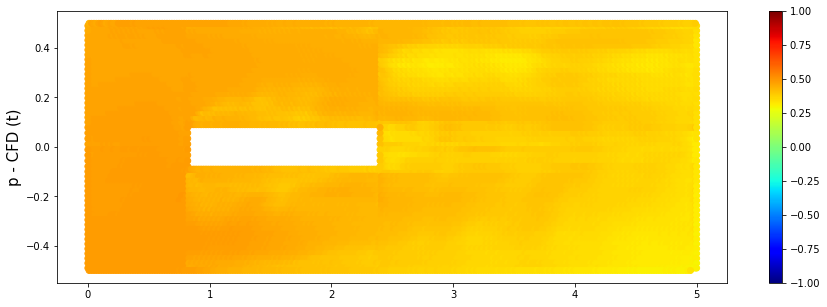

In [111]:
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.

variable = 1

i = 40

indice = index(np.array(y_test[i,:,0]) , -100.0 )[0]
print(indice)
x = x_train[i,:indice,3]
y = x_train[i,:indice,4]

z = y_train[i,:indice,0]

for step, (x_) in enumerate(data):
  x_model = x_

z_model = model(x_model)
fig = plt.figure(figsize=(15,5))

plt.ylabel('p - CFD (t)', fontsize=15)
plt.scatter(x, y, c=z_model[:,:indice,0], cmap='jet', vmax = 1, vmin=-1)
#plt.scatter(x, y, c=x_model[:,:indice,0], cmap='jet', vmax = 3, vmin=-2)
plt.colorbar()


x,y,t - inputs

In [ ]:
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx
    # If no item was found return None, other return types might be a problem due to
    # numbas type inference.



sim= 0
variable = 1
indice = index(np.array(y_test[sim*50 +1 ,:,0]) , -100.0 )[0]
path='/content/plots/'

try:
    shutil.rmtree(path)
except OSError as e:
    print ("")

os.makedirs(path)



for i in range(5):

  x = x_test[i,:indice,3]
  y = x_test[i,:indice,4]
  z_model = model(x_test[i,:,0:3].reshape((1,) + (13104,3)))[:,:indice,:]
  print(z_model.shape)
  fig = plt.figure(figsize=(20,20))

  plt.subplot(412)
  plt.ylabel('p - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,2], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:indice,2]
  z = y_test[i,:indice,2]

  plt.subplot(413)
  plt.ylabel('p - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('p - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/p' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('ux - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,0], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:indice,0]
  z = y_test[i,:indice,0]


  plt.subplot(413)
  plt.ylabel('ux -CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('ux - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/ux' + str(i) + '.png')
  plt.close()

  fig = plt.figure(figsize=(20,20))
  plt.subplot(412)
  plt.ylabel('uy - Prediction (t)', fontsize=15)
  plt.scatter(x, y, c=z_model[0,:,1], cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  z_partida = x_test[i,:indice,1]
  z = y_test[i,:indice,1]

  plt.subplot(413)
  plt.ylabel('uy - CFD (t)', fontsize=15)
  plt.scatter(x, y, c=z, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  plt.subplot(411)
  plt.ylabel('uy - CFD (t-1)', fontsize=15)
  plt.scatter(x, y, c=z_partida, cmap='jet', vmax = 1, vmin=0)
  plt.colorbar()

  #plt.show()
  plt.subplots_adjust(left=0.2, wspace=0.8, top=0.85)
  plt.savefig('/content/plots/uy' + str(i) + '.png')
  plt.close()



(1, 12640, 3)
(1, 12640, 3)
(1, 12640, 3)
(1, 12640, 3)
(1, 12640, 3)


In [ ]:
filenamesp = []
filenamesux = []
filenamesuy = []
for i in range(49):
  filenamesp.append("/content/plots/p" + str(i) +".png") #hardcoded to get the frames in order
  filenamesux.append("/content/plots/ux" + str(i) +".png") #hardcoded to get the frames in order
  filenamesuy.append("/content/plots/uy" + str(i) +".png") #hardcoded to get the frames in order

In [ ]:
import imageio

with imageio.get_writer('/content/p_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesp:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/content/ux_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesux:
        image = imageio.imread(filename)
        writer.append_data(image)

with imageio.get_writer('/content/uy_movie.gif', mode='I', duration =0.5) as writer:
    for filename in filenamesuy:
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
import glob
from PIL import Image

# filepaths
fp_in = "/content/plots/p*.png"
fp_out = "/content/image.gif"

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)


In [ ]:
import os
import imageio

png_dir = '/content/plots'
images = []
for file_name in sorted(os.listdir(png_dir)):
    if file_name.endswith('.png'):
        file_path = os.path.join(png_dir, file_name)
        images.append(imageio.imread(file_path))
imageio.mimsave('movie.gif', images,fps=10)